# Kalman Theory


## Multivariate notations

variables: 
* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function
* $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance.
* $\mathbf H$ measurment function
$$
* 

\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}

$$

as seen in litrature:

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

# Kalman implementation 
## Auxiliary functions


In [1]:
from numpy.random import randn
import math
import numpy as np
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
from kf_book.mkf_internal import plot_track
from dataclasses import dataclass
import matplotlib.pyplot as plt

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)


@dataclass
class KalmanParams:
    description: str
    F_dynamic: callable  # Function to compute F
    F_static: np.ndarray 
    R: np.ndarray
    Q: np.ndarray
    H: np.ndarray
    x: np.ndarray
    P: np.ndarray

    # def F(self):
    #     return self.F_dynamic(self,gamma_tot)
    
    def __repr__(self):
        max_key_len = max(len(key) for key in vars(self).keys())
        lines = []
    
        for key, value in vars(self).items():
            key_str = f"{key.ljust(max_key_len)} : "
            value_str = str(value)
    
            # If the value spans multiple lines, indent all but the first line
            if '\n' in value_str:
                value_lines = value_str.split('\n')
                indented_value = '\n'.join(' ' * (max_key_len + 3) + line for line in value_lines)
                lines.append(f"{key_str}\n{indented_value}")
            else:
                lines.append(f"{key_str}{value_str}")
        
        return '\n'.join(lines)
    
    def savePaperValues(self,gamma0,gamma1,omega0,fs): #for logging, not for the filter istself (with those paramerters F is calculated)
        self.gamma0 = gamma0
        self.gamma1 = gamma1 
        self.omega0 = omega0
        self.fs = fs
        
            
@dataclass
class Data_samples:
    zs: np.ndarray
    time: np.ndarray
    fs: float
    track: np.ndarray

## Dog-walking parameters - example

In [2]:

# model data
dt = 1.
R_var = 10
Q_var = 0.01


F = np.array([[1, dt],
             [0,  1]])

R = np.array([[R_var]])
Q = Q_var #usually Q is matrix, here scalar for dog example
H = np.array([[1., 0.]])

# initial data 
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])

params_dog = KalmanParams(F_static=F,F_dynamic=None, R=R, Q=Q, H=H, x=x, P=P,description="Example params for a walking dog")
print(params_dog)

#creating data
count_dog = 50
track_dog, zs_dog = compute_dog_data(params_dog.R[0][0], params_dog.Q, count_dog,dt=1) 
data_samples_dog = Data_samples(zs=zs_dog,time=None,fs=None,track=track_dog)

description : Example params for a walking dog
F_dynamic   : None
F_static    : 
              [[1. 1.]
               [0. 1.]]
R           : [[10]]
Q           : 0.01
H           : [[1. 0.]]
x           : 
              [[10. ]
               [ 4.5]]
P           : 
              [[500   0]
               [  0  49]]


## fitterPy implementaion

In [3]:

def pos_vel_filter(x, P, R, Q,F):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = F
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=Q) #should only called on dog example
    else:
        kf.Q[:] = Q
    return kf


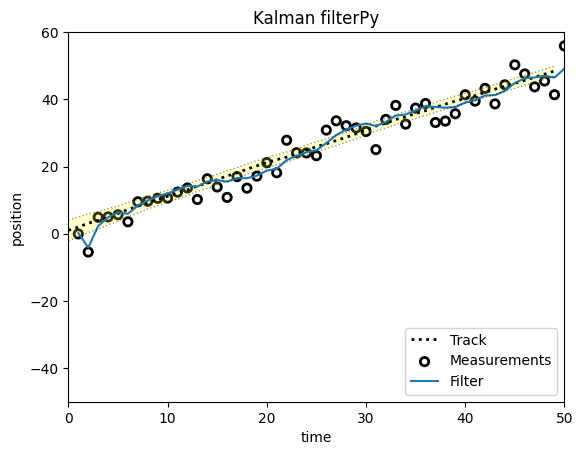

In [4]:

def kalman_filterPy(kalman_params,zs):
    kf = pos_vel_filter(x=kalman_params.x, R=kalman_params.R, P=kalman_params.P, Q=kalman_params.Q, F=kalman_params.F_static) 
    s = Saver(kf)
    for z in zs:
        kf.predict()
        kf.update(z)
        s.save()  # save the current state
    
    # print(s.keys)
    s.to_array()
    return s

s = kalman_filterPy(params_dog,zs_dog)
plot_track(s.x[:, 0], data_samples_dog.track, s.z, s.P,plot_P=False,title="Kalman filterPy")

## Matrices implemenation

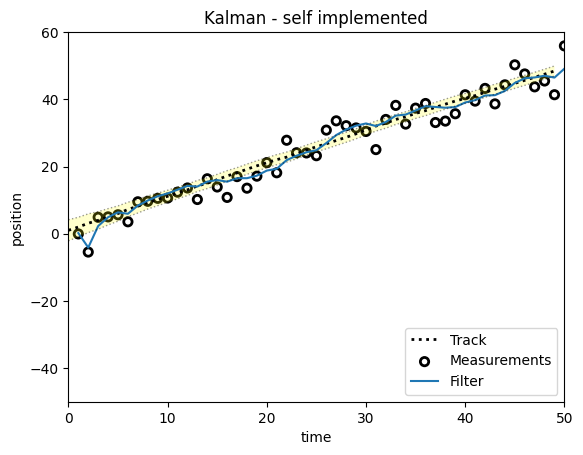

In [5]:


from scipy.linalg import inv

def matrices_implementation(kalman_params,zs):
    x = kalman_params.x
    F = kalman_params.F_static
    
    H = kalman_params.H
    R = kalman_params.R
    P = kalman_params.P
    Q = kalman_params.Q
    
    
    xs, Ps = [], []
    for z in zs:
        # predict
        x = F @ x
        P = F @ P @ F.T + Q
        
        #update
        S = H @ P @ H.T + R
        K = P @ H.T @ inv(S)
        y = z - H @ x
        x += K @ y
        # P = P - K @ H @ P
        P = (np.eye(2) - K @ H) @ P @ (np.eye(2)- K @ H).T + R * (K @ K.T) ## unclear K dimentions 
        
        xs.append(x)
        Ps.append(P)
    
    xs, Ps = np.array(xs), np.array(Ps)
    return xs, Ps

xs, Ps = matrices_implementation(params_dog,zs_dog)
plot_track(xs[:, 0], data_samples_dog.track, zs_dog, Ps, plot_P=False, title="Kalman - self implemented")

# Kalman on Recorded Data
## Loading recorded data


In [6]:
import pandas as pd

# Load the CSV file
file_path = "data/scopeData01.csv"  # Update with your file path
df = pd.read_csv(file_path)


# Ensure time values are sorted in ascending order
df = df.sort_values(by="TIME ms")
df = df.reset_index(drop=True)

# Trim whitespace from column names
df.columns = df.columns.str.strip()

zs_recorded = df["IN2"]
data_samples_recording = Data_samples(zs=zs_recorded,time=df["TIME ms"],fs=204800,track=None)

## Creating model generated data

Secular frequency: 1873 Hz


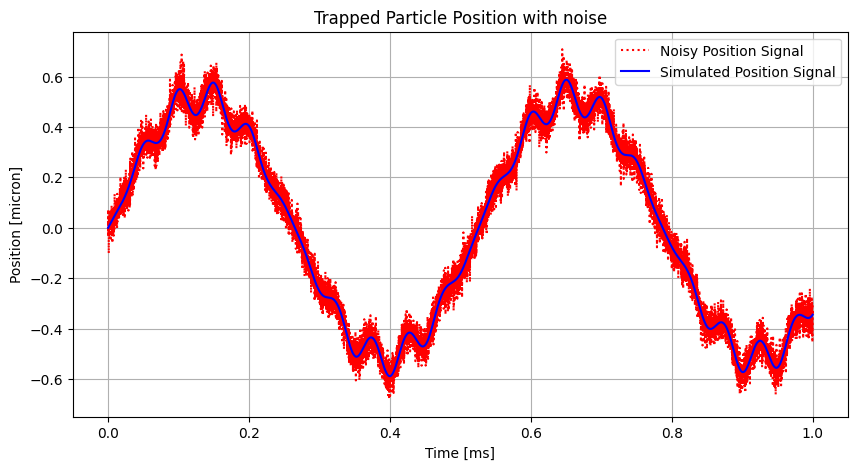

In [7]:
#ben's code for harmonic oscillator model

from scipy.signal import butter, lfilter
from scipy.integrate import solve_ivp

# Compute derivative
def compute_derivative(signal, time):
    return np.gradient(signal, time)

# Generate random velocity based on Boltzmann distribution
def random_velocity_3d(mass, temperature=300):
    k_B = 1.380649e-23  # Boltzmann constant in J/K
    mean_squared_velocity = (3 * k_B * temperature) / mass
    velocity_x = np.random.normal(0, np.sqrt(mean_squared_velocity / 3))
    velocity_y = np.random.normal(0, np.sqrt(mean_squared_velocity / 3))
    velocity_z = np.random.normal(0, np.sqrt(mean_squared_velocity / 3))
    return np.array([velocity_x, velocity_y, velocity_z])

# Simulated position data from the particle trap simulation
def get_simulated_particle_position():
    from scipy.integrate import solve_ivp

    def equations_of_motion_endcap(t, state, Q, m, V_user, Omega, z0):
        x, y, z = state[:3]
        vx, vy, vz = state[3:]

        # Electric field components derived from the quadrupole potential
        Ex = (V_user * np.cos(Omega * t) * x) / z0**2
        Ey = (V_user * np.cos(Omega * t) * y) / z0**2
        Ez = - (2 * V_user * np.cos(Omega * t) * z) / z0**2

        # Compute acceleration
        ax = (Q / m) * Ex
        ay = (Q / m) * Ey
        az = (Q / m) * Ez

        # Return derivatives
        derivatives = [vx, vy, vz, ax, ay, az]
        return derivatives

    # Initial conditions
    initial_position = np.array([0.0, 0.0, 0.0])  # Starting at trap center
    initial_velocity = random_velocity_3d(m)  # Assign velocity from Boltzmann distribution
    initial_state = np.concatenate((initial_position, initial_velocity))

    # Time span
    t_start = 0
    t_end = 1e-3  # Simulate for 1 millisecond
    num_points = 10000  # Number of time points
    t_eval = np.linspace(t_start, t_end, num_points)

    # Solve equations of motion
    solution = solve_ivp(
        equations_of_motion_endcap,
        (t_start, t_end),
        initial_state,
        t_eval=t_eval,
        args=(Q, m, V_AC, Omega, z0),
        rtol=1e-8,
        atol=1e-10
    )

    # Extract z-position over time
    time = solution.t
    position_z = solution.y[2]  # z-axis position

    return time, position_z

# Get simulated position data
# Simulation parameters
Q = 100 * 1.602e-19  # Charge in Coulombs
m = 2.5e-17  # Mass in kg (approximate for a nanoparticle)
V_AC = 800.0  # Trap AC voltage
Omega = 2 * np.pi * 20e3  # Drive frequency in rad/s
z0 = 0.0007  # Characteristic trap dimension in meters

time, position_signal = get_simulated_particle_position()
fs = 1 / np.mean(np.diff(time))  # Compute sampling frequency dynamically

# Calculate estimated secular frequency
sec_freq = np.sqrt(2) * Q * V_AC / (m * z0**2 * Omega)
print("Secular frequency:", int(sec_freq / (2 * np.pi)), "Hz")

# Add Gaussian noise
noise_std = 0.1 * np.std(position_signal)
noisy_position_signal = position_signal + np.random.normal(0, noise_std, size=position_signal.shape)


# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time * 1e3, noisy_position_signal * 1e6, label='Noisy Position Signal', linestyle='dotted', color='red')
plt.plot(time * 1e3, position_signal * 1e6, label='Simulated Position Signal', color='blue')
plt.xlabel('Time [ms]')
plt.ylabel('Position [micron]')
plt.title('Trapped Particle Position with noise')
plt.legend()
plt.grid()
plt.show()

data_samples_simulated_by_model = Data_samples(zs=noisy_position_signal,time=time,fs=fs,track=position_signal) 

## Parameters - paper model

In [8]:
def F_paper(Ts,omega0,gamma_tot):
    wk = math.sqrt(omega0**2 - (gamma_tot**2/4))
    F11 = (gamma_tot * math.sin(wk * Ts) / (2 * wk)) + math.cos(wk * Ts)
    F12 = (1 / wk) * math.sin(wk * Ts)
    
    F21 = -((gamma_tot**2 / (4 * wk)) + wk) * math.sin(wk * Ts)
    F22 = F11
    
    F = np.exp(-gamma0*Ts/2) * np.array([[F11, F12],
                                        [F21, F22]])
    return F

### params for recorded data

In [9]:


fs = 204800
gamma0 = 0.1
gamma1 = 0
omega0 = 2*math.pi*15200
paperParams_recorded_data = KalmanParams(F_static=F_paper(Ts=1/fs,omega0=2*math.pi*15200,gamma_tot=gamma0 + gamma1),
                           F_dynamic=F_paper,
                           R=np.array([[0.01]]),
                           Q=Q_discrete_white_noise(dim=2, dt=1, var=0.1),
                           H=np.array([[1., 0.]]),
                           x=np.array([-3.155211e-02,0]),
                           P=np.array([[0.180368 ,0],
                                      [0 ,0.175440]]),
                           description="paper params, chosen for RECORDED data")
paperParams_recorded_data.savePaperValues(gamma0,gamma1,omega0,fs)
print(paperParams_recorded_data)

95504.41666911662
description : paper params, chosen for RECORDED data
F_dynamic   : <function F_paper at 0x168e2bb80>
F_static    : 
              [[ 8.93224319e-01  4.70775317e-06]
               [-4.29398573e+04  8.93224319e-01]]
R           : [[0.01]]
Q           : 
              [[0.025 0.05 ]
               [0.05  0.1  ]]
H           : [[1. 0.]]
x           : [-0.03155211  0.        ]
P           : 
              [[0.180368 0.      ]
               [0.       0.17544 ]]
gamma0      : 0.1
gamma1      : 0
omega0      : 95504.41666912971
fs          : 204800


### params for simulated data

In [10]:
fs = 204800
gamma0 = 0.1
gamma1 = 0
omega0 = 2*math.pi*15200
paperParams_simulated_data = KalmanParams(F_static=F_paper(Ts=1/fs,omega0=2*math.pi*15200,gamma_tot=gamma0 + gamma1),
                           F_dynamic=F_paper,
                           R=np.array([[0.01]]),
                           Q=Q_discrete_white_noise(dim=2, dt=1, var=0.1),
                           H=np.array([[1., 0.]]),
                           x=np.array([0.1,0]),
                           P=np.array([[0.0001 ,0],
                                      [0 ,0.0001]]),
                           description="paper params, chosen for SIMULATED data")
paperParams_simulated_data.savePaperValues(gamma0,gamma1,omega0,fs)
print(paperParams_recorded_data)

95504.41666911662
description : paper params, chosen for RECORDED data
F_dynamic   : <function F_paper at 0x168e2bb80>
F_static    : 
              [[ 8.93224319e-01  4.70775317e-06]
               [-4.29398573e+04  8.93224319e-01]]
R           : [[0.01]]
Q           : 
              [[0.025 0.05 ]
               [0.05  0.1  ]]
H           : [[1. 0.]]
x           : [-0.03155211  0.        ]
P           : 
              [[0.180368 0.      ]
               [0.       0.17544 ]]
gamma0      : 0.1
gamma1      : 0
omega0      : 95504.41666912971
fs          : 204800


## Running & Analyzing (filterpy) 

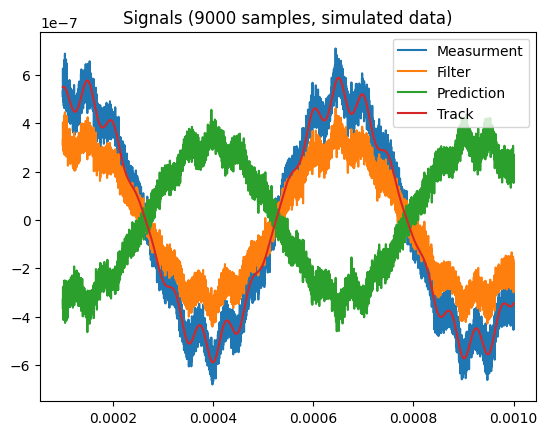

MSE for filterPy and matrices implementaion: 0.0, total of 9000 samples.


In [11]:


# ~~ choose either the recored data (first block)
# ~~ or simulated data (second block)

###~~~~~~~option #1 recorded data~~~~~~~~~ 
# experiment_data = {
#     "start_sample" : 800, 
#     "end_sample":-1, #take until last sample
#     "k_params":paperParams_recorded_data,
#     "data_samples":data_samples_recording,
#     "description": "recorded data"
# }

###~~~~~~~option #2 simulated data~~~~~~~~~
experiment_data = {
    "start_sample" : 1000, 
    "end_sample":-1, #take until last sample
    "k_params":paperParams_simulated_data,
    "data_samples":data_samples_simulated_by_model,
    "description": "simulated data"
}


s = kalman_filterPy(experiment_data["k_params"],experiment_data["data_samples"].zs)
data_x = s.x
data_z = s.z
data_x_prior = s.x_prior
data_K = s.K
# matrices implementation
data_m_x, data_m_z = matrices_implementation(experiment_data["k_params"],experiment_data["data_samples"].zs)

# choose part of the data to analyze
start_sample = experiment_data["start_sample"]
end_sample = len(experiment_data["data_samples"].time) if experiment_data["end_sample"]==-1 else experiment_data["end_sample"]
time_axis = experiment_data["data_samples"].time[start_sample:end_sample]
data_x = data_x[start_sample:end_sample]
data_z = data_z[start_sample:end_sample]
data_x_prior = data_x_prior[start_sample:end_sample]
data_K = data_K[start_sample:end_sample]

data_m_x = data_m_x[start_sample:end_sample]
data_m_z = data_m_z[start_sample:end_sample]
data_track = None if experiment_data["data_samples"].track is None else experiment_data["data_samples"].track[start_sample:end_sample]

# plot data
plt.plot(time_axis,data_z,label="Measurment")
plt.plot(time_axis,data_x[:, 0],label="Filter")
plt.plot(time_axis,data_x_prior[:,0],label="Prediction")
if data_track is not None:
    plt.plot(time_axis,data_track,label="Track")

plt.title("Signals (" + str(len(time_axis)) + " samples, " + experiment_data["description"] + ")")
plt.legend()
plt.show()

mse = np.mean((data_m_x- data_x) ** 2)
print("MSE for filterPy and matrices implementaion: " + str(mse) + ", total of " + str(len(time_axis)) + " samples.")

### K gain histogram

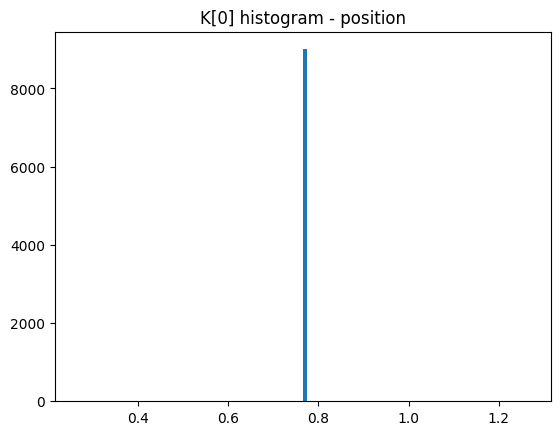

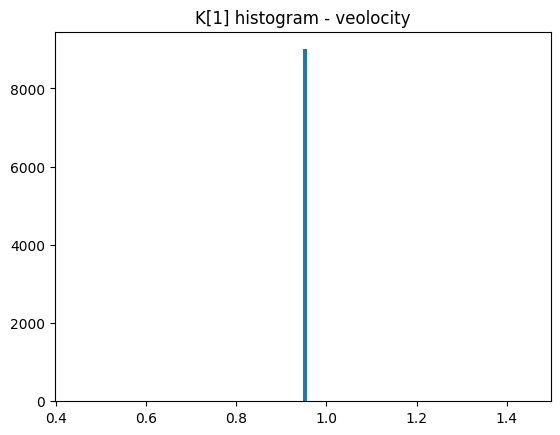

In [12]:

plt.hist(data_K[:,0],bins=100)
plt.title("K[0] histogram - position")
plt.show()

plt.hist(data_K[:,1],bins=100)
plt.title("K[1] histogram - veolocity")
plt.show()

In [13]:
### K gain over time

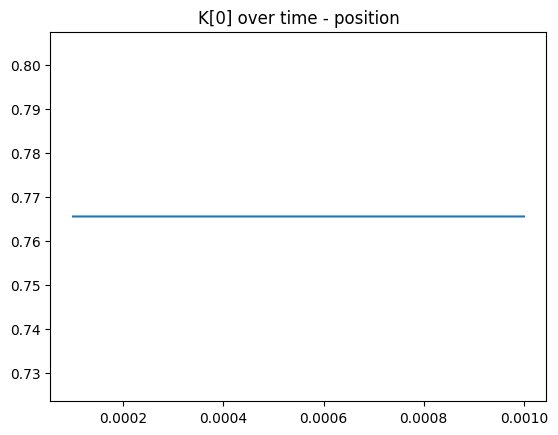

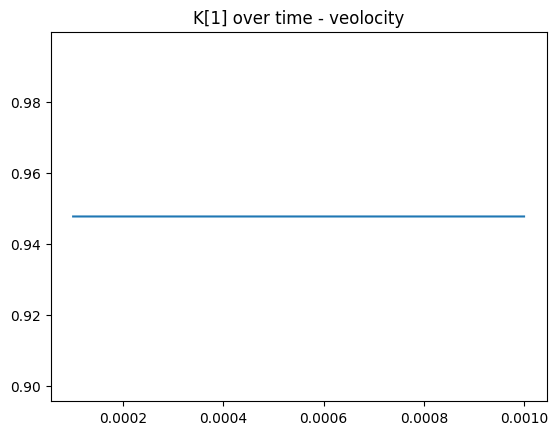

In [14]:
plt.plot(time_axis,data_K[:,0])
plt.title("K[0] over time - position")
plt.show()

plt.plot(time_axis,data_K[:,1])
plt.title("K[1] over time - veolocity")
plt.show()

### power spectrum

2025-04-11 10:38:25,187 - INFO - Sampling frequency (fs): 9999000000.00 Hz
2025-04-11 10:38:25,188 - INFO - Welch's method window size (nperseg): 256
2025-04-11 10:38:25,190 - INFO - Top 3 max power spectral values for measurment:
2025-04-11 10:38:25,190 - INFO -   1. Frequency: 39058593.75 Hz, Power: 0.000000
2025-04-11 10:38:25,190 - INFO -   2. Frequency: 78117187.50 Hz, Power: 0.000000
2025-04-11 10:38:25,191 - INFO -   3. Frequency: 0.00 Hz, Power: 0.000000
2025-04-11 10:38:25,197 - INFO - Top 3 max power spectral values for filter:
2025-04-11 10:38:25,198 - INFO -   1. Frequency: 39058593.75 Hz, Power: 0.000000
2025-04-11 10:38:25,198 - INFO -   2. Frequency: 78117187.50 Hz, Power: 0.000000
2025-04-11 10:38:25,198 - INFO -   3. Frequency: 0.00 Hz, Power: 0.000000
2025-04-11 10:38:25,199 - INFO - Top 3 max power spectral values for prediction:
2025-04-11 10:38:25,200 - INFO -   1. Frequency: 39058593.75 Hz, Power: 0.000000
2025-04-11 10:38:25,200 - INFO -   2. Frequency: 78117187.

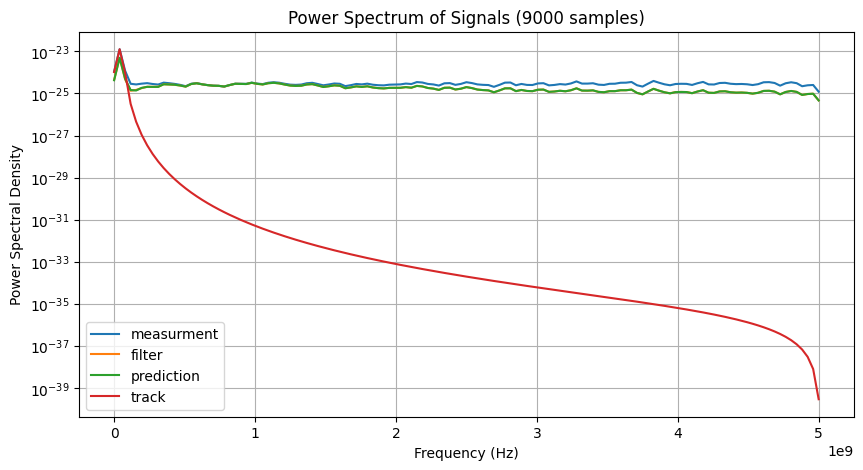

In [15]:
import numpy as np
import scipy.signal
import logging



# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

signals = {
    "measurment": data_z.flatten(),
    "filter": data_x[:, 0].flatten(),
    "prediction": data_x_prior[:,0].flatten(),
    "track": data_track
}

# Define parameters
time_diff = np.mean(np.diff(time_axis))  # Calculate time step
fs = 1 / (time_diff * 1e-3)  # Convert ms to seconds
nperseg = 256  # Window segment size for Welch's method

# Log the parameters used
logging.info(f"Sampling frequency (fs): {fs:.2f} Hz")
logging.info(f"Welch's method window size (nperseg): {nperseg}")
# Function to log the top three maximum values in the power spectrum
def log_top_max(signal, frequencies, power_spectrum,num_of_max):
    # Find indices of the top three maximum values
    top_indices = np.argsort(power_spectrum)[-num_of_max:][::-1]  # Get indices of top 3 in descending order
    top_freqs = frequencies[top_indices]  # Corresponding frequencies
    top_values = power_spectrum[top_indices]  # Corresponding PSD values

    # Log the results
    logging.info(f"Top 3 max power spectral values for {signal}:")
    for i in range(num_of_max):
        logging.info(f"  {i+1}. Frequency: {top_freqs[i]:.2f} Hz, Power: {top_values[i]:.6f}")



# Compute power spectrum for each signal
power_spectrum_results = {}
frequencies = None


    
plt.figure(figsize=(10, 5))
for signal_name, signal_arr in signals.items():
    if signal_arr is None:
        continue
        
    freqs, psd = scipy.signal.welch(signal_arr, fs=fs, nperseg=nperseg)
    power_spectrum_results[signal_name] = psd   # Add small offset to avoid log(0)
    log_top_max(signal_name, freqs, power_spectrum_results[signal_name],3)
    plt.semilogy(freqs, power_spectrum_results[signal_name], label=signal_name)


# Labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectrum of Signals (" + str(len(time_axis)) + " samples)")
plt.legend()
plt.grid()

# Show the plot
plt.show()